**Business Problem:** A company launching an eCommerce store. Currently, the pre-launch page is collecting emails from site visitors. The plan is to collect as many emails for the website launch. 

The objective of this notebook is to run and analyze an AB experiment that tests two versions of the email sign-up on the pre-launch page.

The control is the blue submit button, which is the current version. The treatment is the green submit buton.

In [1]:
# Built-in libraries
from datetime import datetime
import random
import math

# Third-party libraries
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep


# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set seed for np random
SEED = 123
np.random.seed(SEED)

## Load Data

#### Features:
#### experiment: whether the user is involved in AA test or not.
#### group: whether the user belongs to control(0) to treatment group(1)
#### submitted: whether the user entered his email address or not.

In [2]:
# Set data path and load data
data_path = r'HIDDEN'
pretest = pd.read_csv(data_path+'\\pretest.csv'); print('Pretest Data Imported!')
test = pd.read_csv(data_path+'\\test.csv'); print('Test Data Imported!')

# Set date fields as date_time
pretest['date'] = pd.to_datetime(pretest['date'], format='%Y-%m-%d', errors='coerce')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d', errors='coerce')

Pretest Data Imported!
Test Data Imported!


## Understand the Business Problem

The first crucial step in AB testing is to understand the business problem. A vital aspect in understanding the business problem is exploring the data.

In [3]:
# Display the first five rows of the pretest table
pretest.head()

,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0
3,4,2021-12-01,NaN,NaN,NaN,0
4,5,2021-12-01,NaN,NaN,NaN,0


In [4]:
# Show stats about the pretest table

# A. How many rows are in the table?
# B. What's the date range of the date field in the table?

print('# of rows:', pretest.shape[0])
print('Date range:', pretest.date.min().date(), '-', pretest.date.max().date())

# of rows: 309903
Date range: 2021-12-01 - 2021-12-31


In [5]:
# Let's check for missingness. What's the null rate per column?
pretest.isnull().mean()

visitor_id    0.000000
date          0.000000
email         0.899017
experiment    0.903070
group         0.903070
submitted     0.000000
dtype: float64

In [6]:
# Let's get some stats about the pretest performance 

# A. How many visitors were there?
# B. How many sign-ups were there
# C. What was the sign-up rate?

print('Total visitor count:', pretest.visitor_id.nunique())
print('Sign-up count:', pretest.submitted.sum())
print('Sign-up rate:', pretest.submitted.mean().round(2))

Total visitor count: 309903
Sign-up count: 31295
Sign-up rate: 0.1


### Plot Visitor per Day

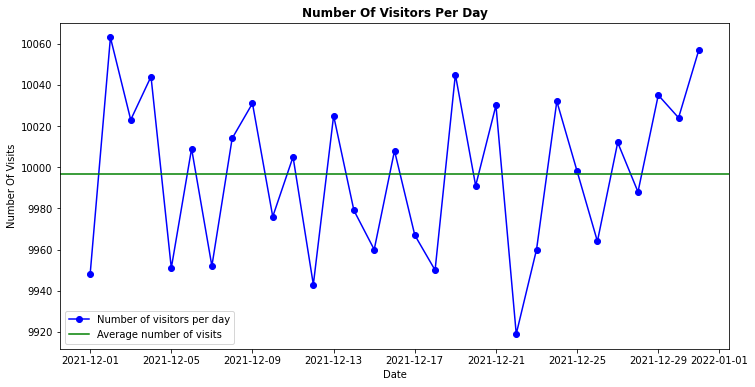

In [7]:
# Count sign-ups by date
visitors_per_day = pretest.groupby('date')['submitted'].count()
visitors_per_day_avg = visitors_per_day.mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(visitors_per_day, marker = 'o', label = 'Number of visitors per day', color = 'blue')
plt.axhline(visitors_per_day_avg, label = 'Average number of visits', color = 'green')
plt.xlabel('Date')
plt.ylabel('number of visits'.title())
plt.title('number of visitors per day'.title(), weight = 'bold')
plt.legend()
plt.show()

### Plot Sign-Up Rate per Day

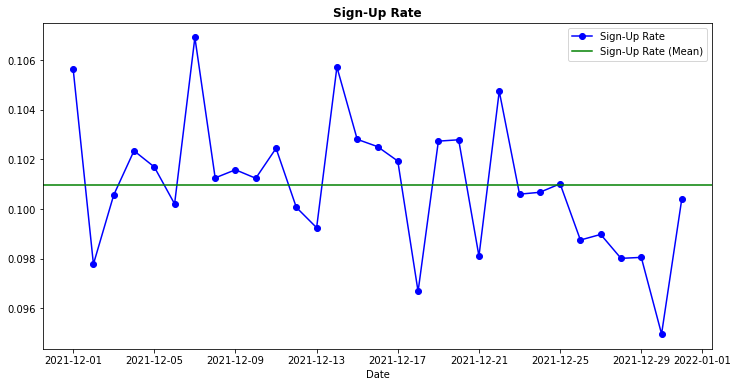

In [8]:
# Get the submission rate per date
signup_rate_per_day = pretest.groupby('date')['submitted'].mean() 
signup_rate_mean = signup_rate_per_day.mean() 

# Plot
plt.figure(figsize=(12, 6))
plt.plot(signup_rate_per_day, marker = 'o', label = 'Sign-Up Rate', color = 'blue')
plt.axhline(signup_rate_mean, label = 'Sign-Up Rate (Mean)', color = 'green')
plt.xlabel('Date')
plt.title('Sign-Up Rate', weight = 'bold')
plt.legend()
plt.show()

## State the Hypothesis

The second step of the experiment is to state the hypothesis. This is followed by setting parameter values such as the significance level (alpha), statistical power and minimum detctable effect (MDE). 

**Ho:** The sign-up rates of blue and green buttons are the same.<br>
**Ha:** The sign-up rates of blue and green buttons are different.

In [9]:
# Experiment parameters
alpha = 0.05  # Set the probability threshold at 0.05. If the p-value is less than 0.05, reject Ho.
power = 0.80  # Ensure that there's 80% chance of detecting an effect with significance
mde = 0.10    # Detect a 10% improvement of the sign-up rate with statistical significance

# Proportions if the effect exists (signup rate)
p1 = 0.10             # Control   (Blue)    current signup rate
p2 = p1 * (1 + p1)    # Treatment (Green)   desired signup rate
lift = (p2 - p1) / p1 # Lift value          desired increase

## Design the Experiment

The third step of the experiment is the design the experiment which involves determining the randomization unit, calculating the sample size and determining the experiment duration. We will explore how to calculate the sample size and experiment duration in this section.

#### Calculate Sample Size

In [10]:
import statsmodels.api as sm
from statsmodels.stats.power import tt_ind_solve_power

# Cohen distance
cohen_D = sm.stats.proportion_effectsize(p1, p2)

# Estimate sample size with power (per group)
sample_size_pg = tt_ind_solve_power(
    effect_size= cohen_D, 
    power = power, 
    alpha = alpha)

# Round up sample size to nearest thousand
sample_size_pg = int(round(sample_size_pg, -3))

print(f'To detect an effect of {lift*100:.0f}% lift from the current signup rate at {p1*100:.0f}%, {sample_size_pg} samples are required per group.',
      f'\nThe total number of required sample size is {sample_size_pg*2}')

To detect an effect of 10% lift from the current signup rate at 10%, 15000 samples are required per group. 
The total number of required sample size is 30000


### Power Plot

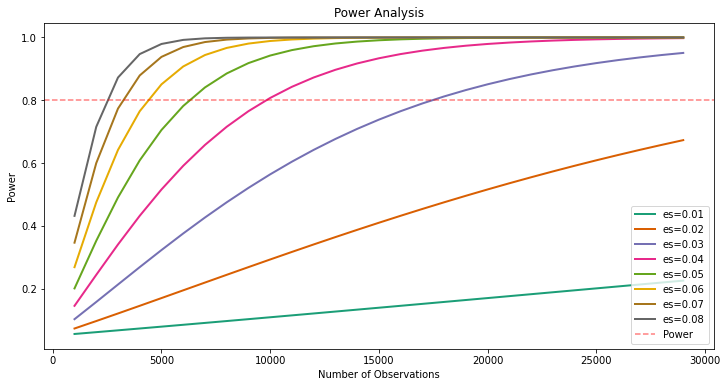

In [11]:
# Plotting power chart
from statsmodels.stats.power import TTestIndPower
f, ax = plt.subplots(figsize = (12,6))
TTestIndPower().plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=np.arange(0.01,.09, 0.01), title='Power Analysis', ax=ax)
ax.axhline(.8, linestyle = 'dashed', color = 'red', label = 'Power', alpha = .5)
ax.set_ylabel('Power')
ax.legend()
plt.show()

#### It can be seen as the effect size decreases, more samples will be needed to reach 80% power. For smaller effect size, this power will not be acheived at all.

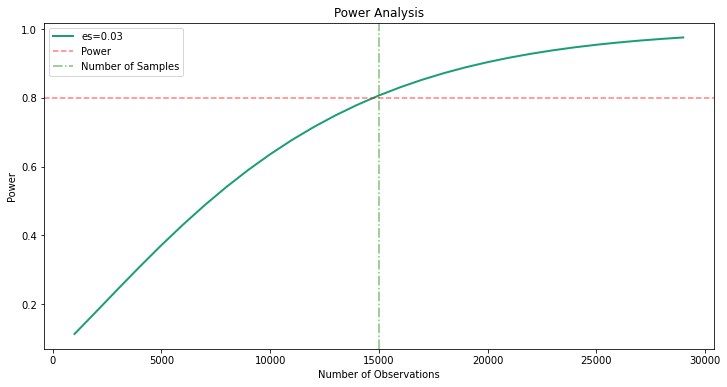

In [12]:
# Plotting power chart for calculated effect size
from statsmodels.stats.power import TTestIndPower
f, ax = plt.subplots(figsize = (12,6))
TTestIndPower().plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[abs(cohen_D)], title='Power Analysis', ax=ax)
ax.axhline(.8, linestyle = 'dashed', color = 'red', label = 'Power', alpha = .5)
ax.axvline(sample_size_pg, linestyle = 'dashdot', color = 'green', label = 'Number of Samples', alpha = .5)
ax.set_ylabel('Power')
ax.legend()
plt.show()

#### Experiment Duration

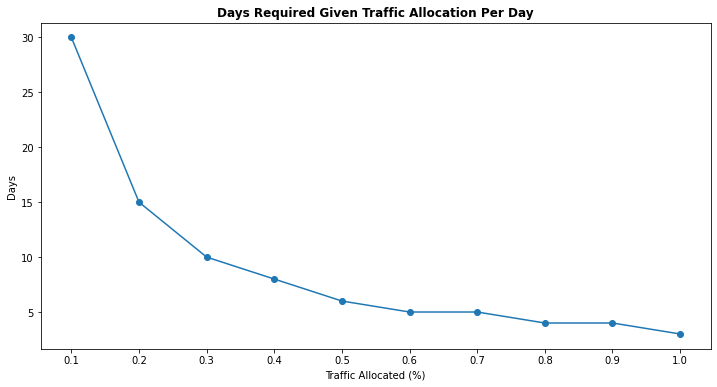

In [13]:
# Days required to capture required samples given different allocation ratio
alloc = np.arange(.1, 1.1, .1)
size = round(visitors_per_day_avg, -3) * alloc
days = np.ceil(2 * sample_size_pg / size)

f, ax = plt.subplots(figsize=(12,6))
ax.plot(alloc, days, marker = 'o')
ax.set_title('days required given traffic allocation per day'.title(), weight = 'bold')
ax.set_xticks(alloc)
ax.set_ylabel('Days')
ax.set_xlabel('traffic allocated (%)'.title())
plt.show()

In [14]:
# Display the number of users required per day in an experiment given the experiment duration.
print(f'For a 21-day experiment, {np.ceil(sample_size_pg * 2 / 21)} users are required per day') # Too long to wait
print(f'For a 14-day experiment, {np.ceil(sample_size_pg * 2 / 14)} users are required per day') # Sweet spot between risk and time
print(f'For a 7-day experiment, {np.ceil(sample_size_pg * 2 / 7)} users are required per day')   # Too risky

For a 21-day experiment, 1429.0 users are required per day
For a 14-day experiment, 2143.0 users are required per day
For a 7-day experiment, 4286.0 users are required per day


#### We set the duration of experiment to 14 days which is more general

## AA test

#### Before running the experiment, we need to do AA test. The main reason of doing AA test is to ensure that the control and treatment groups will start in the same condition. For example, there is not any significant instrumentation effect (like latency or etc) causing the experiment type 1 or 2 error. To meet this, we run AA test by providing both groups a same version of the website and we expect to see same signup rates.

In [15]:
# Filter on visitors in the AA test 
AA_test = pretest[pretest.experiment.str.contains('AA', na=False)]
AA_test.reset_index(drop=True, inplace=True)
num_sample_captured = len(AA_test)
AA_control = AA_test[AA_test.group == 0]['submitted']
AA_treatment = AA_test[AA_test.group == 1]['submitted']

# Get stats
AA_control_count = AA_control.sum()             # Control group number of signups
AA_control_rate = AA_control.mean()             # Control group signup rate
AA_control_size = AA_control.count()            # Number of samples in control group

AA_treatment_count = AA_treatment.sum()         # Treatment group number of signups
AA_treatment_rate = AA_treatment.mean()         # Treatment group signup rate
AA_treatment_size = AA_treatment.count()        # Number of samples in treatment group

# Show stats
print(f'In total, {num_sample_captured} number of samples has been captured.')
print(f'In the Control group, {AA_control_size} number of samples has been captured. {AA_control_count} number of signups has been logged, and the signup rate is {AA_control_rate*100:.2f}%')
print(f'In the Treatment group, {AA_treatment_size} number of samples has been captured. {AA_treatment_count} number of signups has been logged, and the signup rate is {AA_treatment_rate*100:.2f}%')

In total, 30039 number of samples has been captured.
In the Control group, 14982 number of samples has been captured. 1520 number of signups has been logged, and the signup rate is 10.15%
In the Treatment group, 15057 number of samples has been captured. 1488 number of signups has been logged, and the signup rate is 9.88%


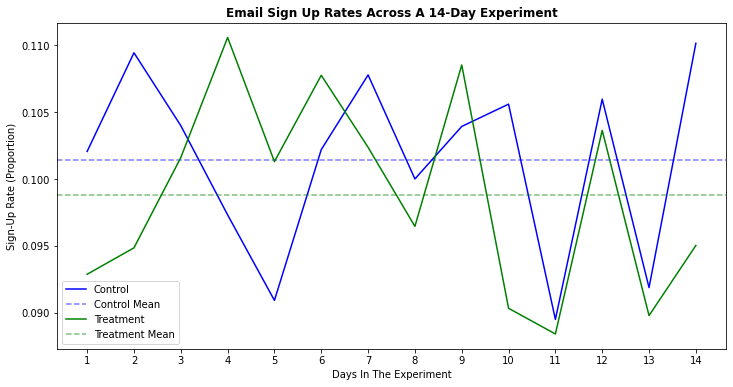

In [16]:
# Visualization

# The proportion of signups per group per day
signups_per_day = AA_test.groupby(['group', 'date'])['submitted'].mean()
control_prop, treatment_prop = signups_per_day[0], signups_per_day[1]
experiment_days = range(1, AA_test.date.nunique()+1)

# Plotting signup fluctuations per group per day over the course of experiment
f, ax = plt.subplots(figsize = (12, 6))
ax.plot(experiment_days, control_prop, label = 'Control', color = 'blue')
ax.axhline(AA_control_rate, label = 'Control Mean', color = 'blue', linestyle = 'dashed', alpha = .5)
ax.plot(experiment_days, treatment_prop, label = 'Treatment', color = 'green')
ax.axhline(AA_treatment_rate, label = 'Treatment Mean', color = 'green', linestyle = 'dashed', alpha = .5)
ax.set_xticks(experiment_days)
ax.set_title('email sign up rates across a 14-day experiment'.title(), weight = 'bold')
ax.set_xlabel('days in the experiment'.title())
ax.set_ylabel('sign-up rate (proportion)'.title())
ax.legend()
plt.show()

#### Now we need to check signup rates for control and treatment groups and make sure that there is not a significant difference between rates. We set the null hypothesis to having the same rate and alternative hypothesis to having different. If there is not a significant difference between control and signup's rate in AA test, we can proceed to do the AB test.

In [17]:
from statsmodels.stats.proportion import proportions_chisquare

# Run a chi-square test
AA_chistats, AA_pvalue, AA_tab = proportions_chisquare(count=[AA_control_count, AA_treatment_count], 
                                                       nobs=[AA_control_size, AA_treatment_size])

# Set the ALPHA for the AA test
AA_ALPHA = 0.05

print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.')
print(f'Significance level: {AA_ALPHA}\n')
print(f'Chi-Square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')
print('\nConclusion:')
if AA_pvalue < AA_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference between the two groups. Check for instrumentation errors.')
else:
  print('Fail to reject Ho. Therefore, proceed with the AB test.')

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.
Significance level: 0.05

Chi-Square = 0.577 | P-value = 0.448

Conclusion:
Fail to reject Ho. Therefore, proceed with the AB test.


## Run the Experiment

We will take a look at the step that involves running an experiment. The code below a simplified version of how data is collected and analyzed in a large scale experiment platform.

In [18]:
# Let's check the number of samples we aimed to capture
AB_test = test.loc[test.experiment.notna()]
AB_test.reset_index(drop=True, inplace=True)
num_sample_captured = len(AB_test)

control_signups = AB_test[AB_test.group == 0]['submitted']
treatment_signups = AB_test[AB_test.group == 1]['submitted']

# Get stats from Control and Treatment groups
AB_control_count = control_signups.sum()         # Control group number of signups
AB_control_size = control_signups.count()        # Number of samples in control group
AB_control_rate = control_signups.mean()         # Control group signup rate

AB_treatment_count = treatment_signups.sum()     # Treatment group number of signups
AB_treatment_size = treatment_signups.count()    # Number of samples in treatment group
AB_treatment_rate = treatment_signups.mean()     # Treatment group signup rate

print(f'In total, {num_sample_captured} number of samples has been captured.')
print(f'In the Control group, {AB_control_size} number of samples has been captured. {AB_control_count} number of signups has been logged, and the signup rate is {AB_control_rate*100:.2f}%')
print(f'In the Treatment group, {AB_treatment_size} number of samples has been captured. {AB_treatment_count} number of signups has been logged, and the signup rate is {AB_treatment_rate*100:.2f}%')

In total, 30081 number of samples has been captured.
In the Control group, 14942 number of samples has been captured. 1428 number of signups has been logged, and the signup rate is 9.56%
In the Treatment group, 15139 number of samples has been captured. 1632 number of signups has been logged, and the signup rate is 10.78%


### Sample Ratio Mismatch (SRM)
#### Although it seems the control and treatment groups have the same size of samples, as a rule of thumb we need to check the ratio mismatch. The ratio mismath can lead to faulty experiment. We check the sample ratio mismatch with Chi-Squared test. This test is suitable to check the observed value with the expected value and conclude that if observed and expected distribution are significantly different or not.

In [19]:
# Check sample ratio with Chi-Squared test
import scipy.stats as stats

observed = AB_test.groupby('group')['experiment'].count().values        # Observed number of samples per group
expected = [AB_test.shape[0]*.5]*2                                      # Desired number of samples per group (1:1)

significance_level = 0.05
chi_stats, p_value = stats.chisquare(f_obs= observed, 
                                     f_exp= expected)

dash_line = '-'.join('' for x in range(50))
print(f'The experiment expected to have {expected[0]} number of samples per group. (1:1)')
print(f'The actual number of samples per group are:',
      f'\nControl group:    {observed[0]}', 
      f'\nTreatment group:  {observed[1]}')
print(dash_line)
print('Assumptions:\n')
print('Ho: The sample ratio is 1:1')
print('Ha: The sample ratio is NOT 1:1')
print(f'Significance level: {significance_level}')
print('\n------- A Chi-Square Test Result for Sample Ratio Mismatch --------\n')
print(f'Chi-Square = {chi_stats:.3f} | p-value = {p_value:.3f}')
print(dash_line)
print('Conclusion:\n')
if p_value > significance_level:
    print(f'At {significance_level} of significance level, the sample size ratio is not significantly different from 1:1.', 
          f'\nFailed to reject the null hypothesis. The observed ratio is statistically accepted to be 1:1.')
else:
    print(f'At {significance_level} of significance level, the sample size ratio is significantly different from 1:1.', 
          f'\nReject the null hypothesis. The observed ratio is NOT statistically accepted to be 1:1.')

The experiment expected to have 15040.5 number of samples per group. (1:1)
The actual number of samples per group are: 
Control group:    14942 
Treatment group:  15139
-------------------------------------------------
Assumptions:

Ho: The sample ratio is 1:1
Ha: The sample ratio is NOT 1:1
Significance level: 0.05

------- A Chi-Square Test Result for Sample Ratio Mismatch --------

Chi-Square = 1.290 | p-value = 0.256
-------------------------------------------------
Conclusion:

At 0.05 of significance level, the sample size ratio is not significantly different from 1:1. 
Failed to reject the null hypothesis. The observed ratio is statistically accepted to be 1:1.


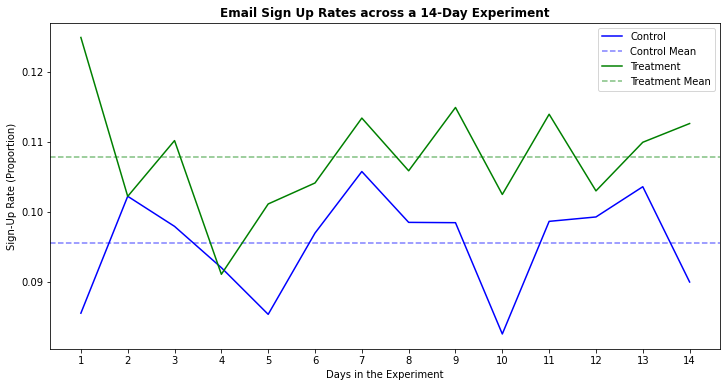

In [20]:
# Visualization
# The proportion of signups per group per day
signups_per_day = AB_test.groupby(['group', 'date'])['submitted'].mean()
control_prop = signups_per_day[0]
treatment_prop = signups_per_day[1]
experiment_days = range(1, AB_test.date.nunique() + 1)

# Plotting signup fluctuations per group per day over the course of experiment
f, ax = plt.subplots(figsize = (12, 6))
ax.plot(experiment_days, control_prop, label = 'Control', color = 'blue')
ax.axhline(AB_control_rate, label = 'Control Mean', color = 'blue', linestyle = 'dashed', alpha = .5)
ax.plot(experiment_days, treatment_prop, label = 'Treatment', color = 'green')
ax.axhline(AB_treatment_rate, label = 'Treatment Mean', color = 'green', linestyle = 'dashed', alpha = .5)
ax.set_xticks(experiment_days)
ax.set_title('Email Sign Up Rates across a 14-Day Experiment', weight = 'bold')
ax.set_xlabel('Days in the Experiment')
ax.set_ylabel('Sign-Up Rate (Proportion)')
ax.legend()
plt.show()

## Conduct Statistical Inference

In this step we will walk through the procedure of applying statistical tests on the email sign-up AB test. We will take a look at Chi-Squared and T-Test to evaluate the results from the experiment. Though, in real life, only one of the tests is sufficient, for learning, it's useful to compare and contrast the result from both.

We will end this step by looking at the confidence interval.

### AB Chi-Squared test 

In [21]:
from statsmodels.stats.proportion import proportions_chisquare

# Run a chi-square test
AB_chistats, AB_pvalue, AB_tab = proportions_chisquare(count=[AB_control_count, AB_treatment_count], 
                                                       nobs=[AB_control_size, AB_treatment_size])

# Set the ALPHA for the AB test
AB_ALPHA = 0.05

# Grabs date range
first_date = AB_test['date'].min().date()
end_date = AB_test['date'].max().date()

print(f'AB Test Email Sign Ups ({first_date} to {end_date})')
print(dash_line)
print('Assumptions:\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.')
print(f'Significance level: {AB_ALPHA}')
print(dash_line)
print('Chi-squared Test Result:\n')
print(f'Chi-Square = {AB_chistats:.3f} | P-value = {AB_pvalue:.3f}')
print(dash_line)
print('Conclusion:\n')
if AB_pvalue < AB_ALPHA:
  print('Reject the Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')

AB Test Email Sign Ups (2022-02-01 to 2022-02-14)
-------------------------------------------------
Assumptions:

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.
Significance level: 0.05
-------------------------------------------------
Chi-squared Test Result:

Chi-Square = 12.312 | P-value = 0.000
-------------------------------------------------
Conclusion:

Reject the Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


### AB T-distribution test

In [22]:
from statsmodels.stats.weightstats import ttest_ind

AB_tstat, AB_pvalue, AB_tab = ttest_ind(treatment_signups,
                                        control_signups, 
                                        alternative= 'two-sided')


# print results
print(f'AB Test Email Sign Ups ({first_date} to {end_date})')
print(dash_line)
print('Assumptions:\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.')
print(f'Significance level: {AB_ALPHA}\n')
print(dash_line)
print('T-distribution Test Result:\n')
print(f'T statistics = {AB_tstat:.3f} | P-value = {AB_pvalue:.3f}')
print(dash_line)
print('Conclusion:\n')
if AB_pvalue < AB_ALPHA:
  print('Reject the Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')


AB Test Email Sign Ups (2022-02-01 to 2022-02-14)
-------------------------------------------------
Assumptions:

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.
Significance level: 0.05

-------------------------------------------------
T-distribution Test Result:

T statistics = 3.509 | P-value = 0.000
-------------------------------------------------
Conclusion:

Reject the Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


### Final Result w/ Confidence Interval

In [23]:
from statsmodels.stats.proportion import confint_proportions_2indep
ci = confint_proportions_2indep(count1=AB_treatment_count, nobs1=AB_treatment_size,
                           count2=AB_control_count, nobs2=AB_control_size,
                           compare='diff', alpha=.05, correction=True)
low, upp = ci[0], ci[1]

# Transform the confidence interval to lift domain
lift_low = low / AB_control_rate
lift_upp = upp / AB_control_rate

# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n--------- Sign-Up Counts (Rates) ----------')
print(f'Control: {AB_control_count} ({AB_control_rate*100:.1f}%)')
print(f'Treatment: {AB_treatment_count} ({AB_treatment_rate*100:.1f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {AB_treatment_rate - AB_control_rate:.4f}')
print(f'Relative (lift): {(AB_treatment_rate - AB_control_rate) / AB_control_rate*100:.1f}%')

print('\n--------- T-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({low:.3f}, {upp:.3f})')
print(f'Relative Difference (lift) CI: ({lift_low*100:.1f}%, {lift_upp*100:.1f}%)')

--------- Sample Sizes ----------
Control: 14942
Treatment: 15139

--------- Sign-Up Counts (Rates) ----------
Control: 1428 (9.6%)
Treatment: 1632 (10.8%)

--------- Differences ----------
Absolute: 0.0122
Relative (lift): 12.8%

--------- T-Stats ----------
Test Statistic: 3.509475
P-Value: 0.00045

--------- Confidence Intervals ----------
Absolute Difference CI: (0.005, 0.019)
Relative Difference (lift) CI: (5.7%, 19.9%)


## Decide Whether to Launch

In the email sign-up test for the company pre-launch page, we aimed to improve the sign-up rate by changing the submit button color from blue to green.

We ran a two-week randomized controlled experiment (02/01/2022 - 02/14/2022) that enrolled a sample of users into the control (blue) and treatment (green) groups.

From the test, we observed an improvement of 12.8% lift from the benchmark (blue) at 9.6%. The result was statistically significant with a 95% confidence interval between 5.7% and 19.9%. 

Given that we observed practical and statistical significance, our recommendation is to launch the new submit button in green.